In [1]:
import numpy as np
from graphviz import Digraph
import matplotlib.pyplot as plt
%matplotlib inline
import math

In [2]:
class Value:
    def __init__(self, data, _parent = (), _op = '', label = ''):
        self.data = data
        self._prev = set(_parent) #here we convert the tuple to a set for efficiency purposes
        self._op = _op
        self.label = label #this here allows us to provide a label also for each of the value object
        self.grad = 0.0 #this is the slope of the output variable w.r.t to the given variable (here variable is a Value object)
        self._backward = lambda: None

    def __repr__(self):
        return f"{self.label}={self.data})"

    #now we want to add two value objects so we defne a method for that
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0*out.grad
            other.grad += 1.0*out.grad
        out._backward = _backward
        return out
    #method to multiply two value objects
    def __mul__(self, other):
        out = Value(self.data*other.data, (self, other), '*')
        def _backward():
            self.grad += other.data*out.grad
            other.grad += self.data*out.grad
        out._backward = _backward
        return out
    #method to use activation func 'tanh'
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) -1)/(math.exp(2*x) +1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1 - t**2)*out.grad
        out._backward = _backward
        return out

    def backprop(self):
       topo = []
       visited = set()
       def build_topo(v):
           if v not in visited:
              visited.add(v)
              for child in v._prev:
                  build_topo(child)
              topo.append(v)
       build_topo(self)

       self.grad = 1.0
       for node in reversed(topo):
           node._backward()


In [3]:
#now we want  a function to visualise these networks as they start to become more complex
from graphviz import Digraph

def trace(root): #build a set of all the nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for parent in v._prev:
                edges.add((parent, v))
                build(parent)

    build(root)
    return nodes,edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) #LR = Left to Right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        #for any value in the graph create a rectangula node for it "record"
        dot.node(name = uid, label = "{%s = data %.4f | grad = %.4f}" % (n.label, n.data, n.grad), shape = 'record')
        if n._op:
            #if value is the result of some operation then we create an operation node for it
            dot.node(name=uid+n._op, label = n._op)
            #connect the node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        #connect n1 to the operations node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

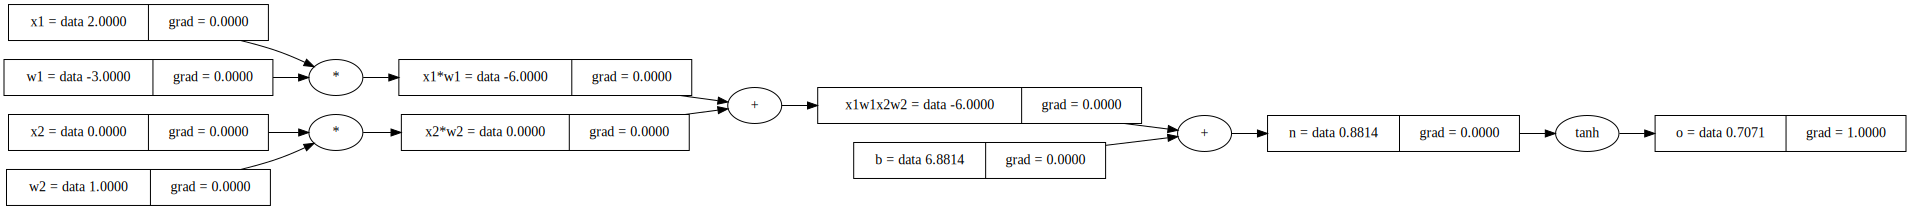

In [4]:
#writing the equation for a neuron
#inputs x1 and x2
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
#weights w1 and w2
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
#the bias 'b'
b = Value(6.8813735870195432, label = 'b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
#the variable before activation function
n = x1w1x2w2 + b; n.label = 'n'

#now we apply the activation function and then get the final value
o = n.tanh()
o.label = 'o'
o.grad = 1.0
draw_dot(o)

In [5]:
o.backprop()

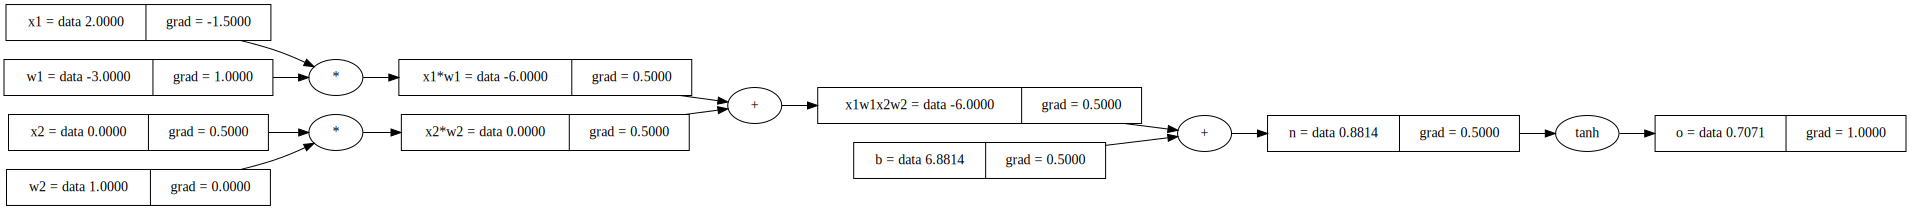

In [6]:
draw_dot(o)

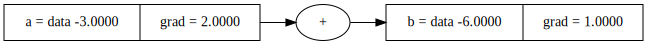

In [7]:
#but here in the code we have a bug that is demonstrated by the below
a = Value(-3, label = 'a')
b = a + a ; b.label = 'b'

b.backprop()
draw_dot(b)
#we see that the gradient for the a is wrong #correct now after we implemented += in Value object

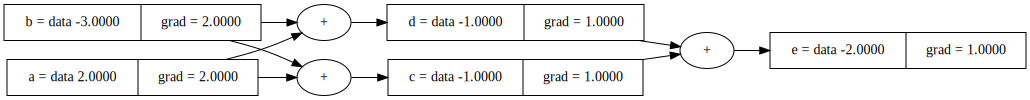

In [8]:
#now we will see this bug with a slightly more complicated example
a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = a + b; c.label = 'c'
d = a + b; d.label = 'd'
e = c + d; e.label = 'e'

e.backprop()
draw_dot(e)
#here we again observe that the grad for a & b is wrong. #correct now after we implemented += in Value object